<a href="https://colab.research.google.com/github/LorenzoBellomo/InformationRetrieval/blob/main/notebooks/1_BaseNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base NLP

In this lecture, we see some standard base NLP pipelines. We need to install a few libraries which are needed for this task.

In [3]:
!pip install unidecode simplejson nltk wordcloud

We will use a lot of libraries

In [4]:
import re
from nltk.corpus import stopwords
from unidecode import unidecode
from nltk.stem.snowball import ItalianStemmer
from collections import Counter
from wordcloud import WordCloud
import nltk
import requests
from IPython.display import Image
import matplotlib.pyplot as plt

%matplotlib inline

nltk.download("stopwords") # nltk needs us to manually download the set of stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Then we will open a file containing our texts. The text is in italian, and as such it has special characters like è and é. This requires us to open it specifying the format (UTF-8).
We take all the words and let the re library (regular expression) handle this splitting.

In [5]:
def get_file_tokens(filename):
    tokens = []
    with open(filename, encoding="utf-8") as f: # here is the line where we open the file
        for line in f:
            tokens += re.split('\W+', line,  flags=re.UNICODE) # re library deals with the splitting
    return tokens

In [9]:
!wget https://raw.githubusercontent.com/LorenzoBellomo/InformationRetrieval-Master/main/data/corano.txt

--2024-06-14 09:36:57--  https://raw.githubusercontent.com/LorenzoBellomo/InformationRetrieval-Master/main/data/corano.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 911699 (890K) [text/plain]
Saving to: ‘corano.txt’

corano.txt          100%[===================>] 890.33K  --.-KB/s    in 0.03s   

2024-06-14 09:36:57 (27.0 MB/s) - ‘corano.txt’ saved [911699/911699]



In [10]:
tokens = get_file_tokens("corano.txt") # the file we open contains the Qaran
print(tokens[:100])
len(tokens)

['', 'Sura', 'I', '', '', 'Al', 'Fâtiha', '', '', 'L', 'Aprente', '1', '', '', '', '', 'Pre', 'Hegira', 'n', '5', 'di', '7', 'versetti', '', '', '', '', '1', 'In', 'nome', 'di', 'Allah', 'il', 'Compassionevole', 'il', 'Misericordioso', '2', '', '', '2', 'La', 'lode', 'appartiene', 'ad', 'Allah', '3', 'Signore', 'dei', 'mondi', '4', '', '', '3', 'il', 'Compassionevole', 'il', 'Misericordioso', '', '', '4', 'Re', 'del', 'Giorno', 'del', 'Giudizio', '5', '', '', '5', 'Te', 'noi', 'adoriamo', 'e', 'a', 'Te', 'chiediamo', 'aiuto', '6', '', '', '6', 'Guidaci', 'sulla', 'retta', 'via', '7', '', '', '7', 'la', 'via', 'di', 'coloro', 'che', 'hai', 'colmato', 'di', 'grazia', '8', 'non']


184123

Now we need to do some statistical analysis on the newly loaded set of words. For that we use the Counter object of the standard collections of Python

In [11]:
c = Counter(tokens)
c["Abramo"] # print the number of times that the token "Abramo" appears

74

In [12]:
len(c) # number of unique tokens

12421

In [13]:
sum(c.values()) # total number of tokens in the document

184123

Now let's see the code to generate the word cloud. We use the matplotlib library only to display it inline on this notebook

In [14]:
def generate_tag_cloud(freq, image_filename=None):
	wc = WordCloud(background_color="white").generate_from_frequencies(freq)
	if image_filename:
        # If you pass it a filename, then it saves the image on the provided path
		image = wc.to_image()
		image.save(image_filename)
	else:
        # then it just displays it here on the notebook
		plt.imshow(wc, interpolation='bilinear')
		plt.axis("off")
		plt.show()

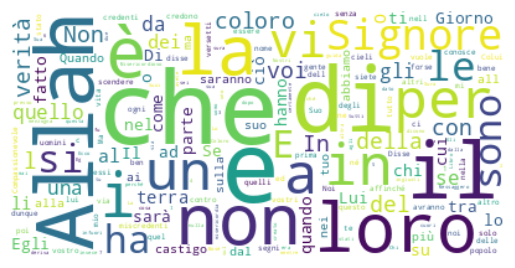

In [15]:
generate_tag_cloud(c)

Nice! We got our first word cloud.
We immediately notice something odd.
- Why do we see "e", "è" and "E" as separate tokens?
- Why do we see them as tokens in the first place?

Let's filter out all the words that are shorter than 3, and re-generate the word clouds

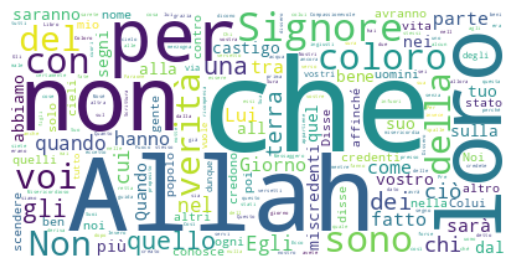

In [16]:
def filter_words(words):
    return [w for w in words if len(w) >= 3]

c = Counter(filter_words(tokens))
generate_tag_cloud(c)

Ok, slightly better, but we can do much better. "che" means "than" in italian, which is surely something that we don't care to see in a word-cloud. Let's filter out all the stopwords.

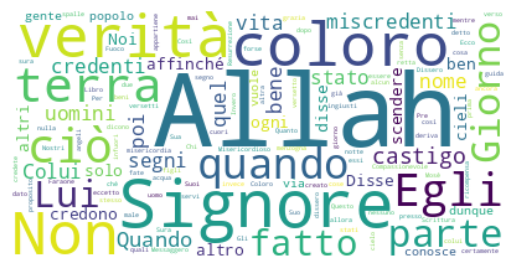

In [17]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('italian'))

def filter_words(words):
    return [w for w in words if len(w)>=3 and w not in STOPWORDS]

c = Counter(filter_words(tokens))
generate_tag_cloud(c)

Even better. But there's some sneaky issues. Say I have a not well formed text, where I have the italian word for "why", written as "perche", "perchè",  "perché", "Perchè", "Perche", "Perché". Those would fall into 6 different tokens in the word cloud. I want them to fall into their "common form".
For this purpose, we perform **normalization** and we also **lowercase** our text.

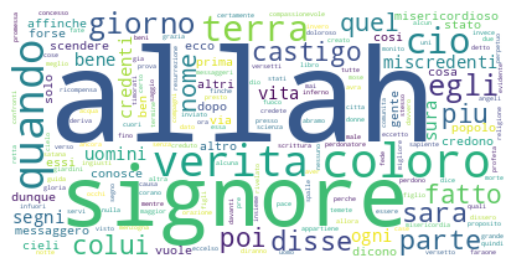

In [18]:
def normalize_words(words):
    return [unidecode(w.lower()) for w in words]

filtered_t = filter_words(normalize_words(tokens))
c = Counter(filtered_t)
generate_tag_cloud(c)

Ok but what about this problem.
"quello", "quella", "quegli", "quelle" are all words that effectively belong to the same semantic group. The only difference is on the "gendered-annotation" and in the singular-plural forms. I want to also group those.
Luckily, there is **stemming** which solves this problem. As you can imagine, stemming algorithms are language based, so we have to specify manually our language.

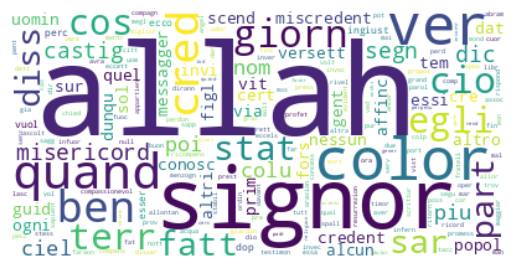

In [19]:
def stem_words(words):
	s = ItalianStemmer()
	return [s.stem(w) for w in words]

c = Counter(stem_words(filtered_t))
generate_tag_cloud(c)

Oh no, we ruined our word cloud. We don't want the "roots" of our words showing here, but how do we solve it?

Well we might substitute the roots with the most common words referring to those roots. We need to create a mapping containing:
```json
{
    "root word": <Counter containing the words and their occcurrence number>
}
```

In [20]:
def get_stem_mapping(words):
	s = ItalianStemmer()
	mapping = {} # here is our mapping
	for w in words:
		stemmed_w = s.stem(w)
		if stemmed_w not in mapping:
			mapping[stemmed_w] = Counter()
		mapping[stemmed_w].update([w])

	return mapping

Then we must create a new function which, given that mapping, is able to de-stem the words.

In [21]:
def destem_words(stems, stem_mapping):
	return [stem_mapping[s].most_common(1)[0][0] for s in stems] # ask the counter to get the most common occurrence for each root word

The full pipeline becomes the following:
1. stem all the filtered tokens (we already did normalization, tokenization...)
2. compute the mapping of the stems
3. de-stem the words.
4. Do the word cloud

In [22]:
stemmed = stem_words(filtered_t)
stem_mapping = get_stem_mapping(filtered_t)
destemmed = destem_words(stemmed, stem_mapping)
c = Counter(destemmed)

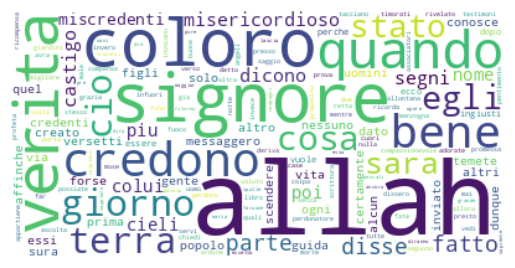

In [23]:
generate_tag_cloud(c)